In [314]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from PIL import Image
import os
import time

from dataset import BrightfieldMicroscopyDataset

from scipy.fft import fft2, ifft2, fftshift, ifftshift

from torch.utils.data import DataLoader
import torch

from tqdm import tqdm
import random

from sklearn.cluster import DBSCAN

In [315]:
train_set = BrightfieldMicroscopyDataset(root_dir_images='data_2/brightfield/', root_dir_labels='data_2/masks', train=True, validation=False)

In [316]:
image = [np.array(Image.open(f)) for f in train_set.image_files[0]]
image = np.stack(image, axis=0)
label = Image.open(train_set.mask_files[0])
label = np.array(label)

image = torch.from_numpy(image)
label = torch.from_numpy(label)

In [317]:
def display_channels(image, figsize=(15, 10), subtitle='Processed'):
    """
    Display individual channels of a multi-channel image.

    Args:
        image (numpy.ndarray): Input image with shape (C, H, W), where C is the number of channels.
        figsize (tuple): Figure size for the plot (width, height).
        subtitle (str): Title for the plot.

    Raises:
        ValueError: If the input image does not have three dimensions.
    """
    # Validate input image dimensions
    if len(image.shape) != 3:
        raise ValueError("Input image must have three dimensions (C, H, W).")

    num_channels = image.shape[0]  # Number of channels in the image

    # Calculate the grid size for subplots
    cols = math.ceil(math.sqrt(num_channels))  # Number of columns
    rows = math.ceil(num_channels / cols)     # Number of rows

    # Create subplots for displaying each channel
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(f"{num_channels}-Channel Image - {subtitle}", fontsize=16)

    # Flatten axes array for easier iteration
    axes = axes.ravel()

    # Display each channel
    for i in range(num_channels):
        ax = axes[i]
        ax.imshow(image[i, ...], cmap="gray")  # Display channel in grayscale
        ax.set_title(f"Channel {i + 1}")
        ax.axis("off")  # Hide axes for cleaner visualization

    # Hide any unused subplots
    for ax in axes[num_channels:]:
        ax.axis("off")

    # Adjust layout to accommodate the suptitle
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Show the plot
    plt.show()


In [318]:
def remove_repeating_pattern(input_image, threshold=0.1, iterations=1):
    """
    Removes repeating patterns from an image using FFT.

    Parameters:
    - image: 2D numpy array, the input image.
    - threshold: float, threshold for identifying peaks in the frequency domain.
    - iterations: int, number of iterations to refine the pattern removal.

    Returns:
    - cleaned_image: 2D numpy array, the image with the pattern removed.
    """
    image = input_image.copy()
    for _ in range(iterations):
        # Step 1: FFT to frequency domain
        f = fft2(image)
        fshift = fftshift(f)
        magnitude = np.abs(fshift)

        # Step 2: Identify pattern frequencies
        mask = magnitude > (threshold * np.max(magnitude))
        pattern_fshift = fshift * mask

        # Step 3: Reconstruct pattern using inverse FFT
        pattern = np.real(ifft2(ifftshift(pattern_fshift)))

        # Step 4: Subtract pattern from original image
        image = image - pattern

    return image

In [319]:
def calculate_segmentation_metrics(predicted_mask, label_mask):
    """
    Calculate segmentation performance metrics.

    Args:
        predicted_mask (numpy.ndarray): Predicted binary segmentation mask
        label_mask (numpy.ndarray): Ground truth binary segmentation mask

    Returns:
        dict: Segmentation performance metrics
    """
    # Ensure masks are binary (0 or 1)
    predicted_mask = (predicted_mask > 0).astype(np.uint8)
    label_mask = (label_mask > 0).astype(np.uint8)

    # Pixel Accuracy: Proportion of correctly classified pixels
    pixel_accuracy = np.sum(predicted_mask == label_mask) / label_mask.size

    # Intersection over Union (IoU)
    intersection = np.logical_and(predicted_mask, label_mask)
    union = np.logical_or(predicted_mask, label_mask)
    iou = np.sum(intersection) / np.sum(union)

    # Dice Coefficient (F1 Score)
    dice_coefficient = (
        2 * np.sum(intersection) / (np.sum(predicted_mask) + np.sum(label_mask))
    )

    # Precision: Proportion of predicted positives that are actually positive
    true_positives = np.sum(np.logical_and(predicted_mask, label_mask))
    predicted_positives = np.sum(predicted_mask)
    precision = true_positives / predicted_positives if predicted_positives > 0 else 0

    # Recall: Proportion of actual positives that are correctly predicted
    actual_positives = np.sum(label_mask)
    recall = true_positives / actual_positives if actual_positives > 0 else 0

    # Specificity: Proportion of actual negatives that are correctly predicted
    true_negatives = np.sum(np.logical_and(predicted_mask == 0, label_mask == 0))
    actual_negatives = np.sum(label_mask == 0)
    specificity = true_negatives / actual_negatives if actual_negatives > 0 else 0

    return {
        "pixel_accuracy": pixel_accuracy,
        "iou": iou,
        "dice_coefficient": dice_coefficient,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
    }

In [320]:
def preprocess_channel(
    channel,
    fft_threshold=0.01,
    fft_iterations=2,
    canny_thresh_min=70,
    canny_thresh_max=80,
    channel_dil=True,
    channel_dil_kernel=3,
    channel_dil_iter=1,
):
    """
    Preprocess a single channel image for segmentation.

    Args:
        channel (np.ndarray): Single channel image
        threshold (float, optional): Threshold for removing repeating patterns. Defaults to 0.01.
        iterations (int, optional): Number of iterations for pattern removal. Defaults to 2.

    Returns:
        np.ndarray: Preprocessed channel image
    """
    # Remove repeating pattern
    cleaned_channel = remove_repeating_pattern(
        channel, threshold=fft_threshold, iterations=fft_iterations
    )

    # Normalize to 0-255 range
    tensor_min = cleaned_channel.min()
    tensor_max = cleaned_channel.max()
    normalized_channel = (
        (cleaned_channel - tensor_min) / (tensor_max - tensor_min) * 255
    )
    normalized_channel = normalized_channel.astype(np.uint8)

    # Edge detection
    edged = cv2.Canny(normalized_channel, canny_thresh_min, canny_thresh_max)

    # Dilation
    if channel_dil:
        dilation_kernel = np.ones((channel_dil_kernel, channel_dil_kernel), np.uint8)
        edged = cv2.dilate(edged, dilation_kernel, iterations=channel_dil_iter)

    return edged


def post_process_segmentation(
    processed_image,
    use_otsu=True,
    otsu_blur_kernel=11,
    otsu_blur_iter=5,
    use_opening=True,
    opening_kernel=10,
    opening_iter=1,
):
    """
    Apply post-processing steps to the segmentation result.

    Args:
        processed_image (np.ndarray): Processed image to refine

    Returns:
        np.ndarray: Refined segmentation result
    """
    # Convert to absolute scale
    img = cv2.convertScaleAbs(processed_image)

    # Gaussian blur and Otsu's thresholding
    if use_otsu:
        blur = cv2.GaussianBlur(
            img, (otsu_blur_kernel, otsu_blur_kernel), otsu_blur_iter
        )
        _, img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological opening
    if use_opening:
        kernel = np.ones((opening_kernel, opening_kernel), np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=opening_iter)

    # Crop and remove border regions
    return crop_image_borders(img)


def crop_image_borders(image, crop_width=15, corner_width=100, corner_height=100):
    """
    Remove border and corner regions from the image.

    Args:
        image (np.ndarray): Input image
        crop_width (int, optional): Width of border to remove. Defaults to 15.
        corner_width (int, optional): Width of corner area to remove. Defaults to 100.
        corner_height (int, optional): Height of corner area to remove. Defaults to 100.

    Returns:
        np.ndarray: Image with borders and corners removed
    """
    cropped = image.copy()

    # Remove borders
    cropped[:crop_width, :] = 0
    cropped[-crop_width:, :] = 0
    cropped[:, :crop_width] = 0
    cropped[:, -crop_width:] = 0

    # Remove corner regions
    cropped[:corner_height, :corner_width] = 0
    cropped[:corner_height, -corner_width:] = 0
    cropped[-corner_height:, :corner_width] = 0
    cropped[-corner_height:, -corner_width:] = 0

    return cropped


def fft_segmentation(
    input_image,
    label,
    channels_to_calculate=None,
    target_size=None,
    
    fft_threshold=0.01,
    fft_iterations=2,
    canny_thresh_min=70,
    canny_thresh_max=80,
    channel_dil_kernel=3,
    channel_dil_iter=1,
    channel_dil=True,

    use_otsu=True,
    use_opening=True,
    otsu_blur_kernel=11,
    otsu_blur_iter=5,
    opening_kernel=10,
    opening_iter=1,
):
    """
    Perform FFT-based segmentation on an image.

    Args:
        input_image (torch.Tensor): Input image tensor
        label (torch.Tensor): Ground truth label
        channels_to_calculate (int, optional): Number of channels to process.
                                               Defaults to all channels.

    Returns:
        tuple: Processed image, original label, segmentation metrics, and execution time
    """
    # Start timing
    start_time = time.time()

    if target_size is not None:
        if len(input_image.shape) == 3:  # [C, H, W](512, 512)
            resized_channels = []
            for c in range(input_image.shape[0]):  # Loop over all 11 channels
                channel = input_image[c]
                resized_channel = cv2.resize(channel.numpy(), target_size, interpolation=cv2.INTER_LINEAR)
                resized_channels.append(resized_channel)

            # Stack channels back together into a single array
            image = np.stack(resized_channels, axis=0)
            label = cv2.resize(label.numpy(), target_size, interpolation=cv2.INTER_LINEAR)
        else:
            print(f"Unexpected image shape: {image.shape}")
            raise ValueError("Image must have 3D shape [C, H, W]")
    else:
        image = input_image.numpy()
        label = label.numpy()

    channels = image.shape[0]
    image_np = image.copy()

    if channels_to_calculate is None:
        channels_to_calculate = channels

    # Process channels and store them in a NumPy array
    processed_channels = np.zeros(
        (channels_to_calculate, image_np.shape[1], image_np.shape[2]), dtype=np.uint8
    )

    for i in range(channels_to_calculate):
        processed_channels[i] = preprocess_channel(
            channel=image_np[i],
            fft_threshold=fft_threshold,
            fft_iterations=fft_iterations,
            canny_thresh_min=canny_thresh_min,
            canny_thresh_max=canny_thresh_max,
            channel_dil=channel_dil,
            channel_dil_kernel=channel_dil_kernel,
            channel_dil_iter=channel_dil_iter,
        )

    # Average processed channels
    averaged_image = np.mean(processed_channels, axis=0)

    processed_image = post_process_segmentation(
        processed_image=averaged_image,
        use_otsu=use_otsu,
        otsu_blur_kernel=otsu_blur_kernel,
        otsu_blur_iter=otsu_blur_iter,
        use_opening=use_opening,
        opening_kernel=opening_kernel,
        opening_iter=opening_iter,
    )
    metrics = calculate_segmentation_metrics(processed_image, label)

    # End timing
    end_time = time.time()
    execution_time = end_time - start_time

    return processed_image, processed_channels, label, metrics, execution_time

In [321]:
postprocessed_image, preprocessed_channels, label, metrics, execution_time = fft_segmentation(
    input_image=image,
    label=label,
    channels_to_calculate=None,
    target_size=None,

    #preprocessing
    fft_threshold=0.01,
    fft_iterations=2,
    canny_thresh_min=70,
    canny_thresh_max=80,
    channel_dil_kernel=3,
    channel_dil_iter=1,
    channel_dil=True,

    #postprocessing
    use_otsu=True,
    otsu_blur_kernel=11,
    otsu_blur_iter=5,
    use_opening=True,
    opening_kernel=10,
    opening_iter=1,
)

In [322]:
print("Segmentation Metrics:")
for metric, value in metrics.items():
    print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

Segmentation Metrics:
Pixel Accuracy: 0.9701
Iou: 0.5868
Dice Coefficient: 0.7396
Precision: 0.6960
Recall: 0.7889
Specificity: 0.9804


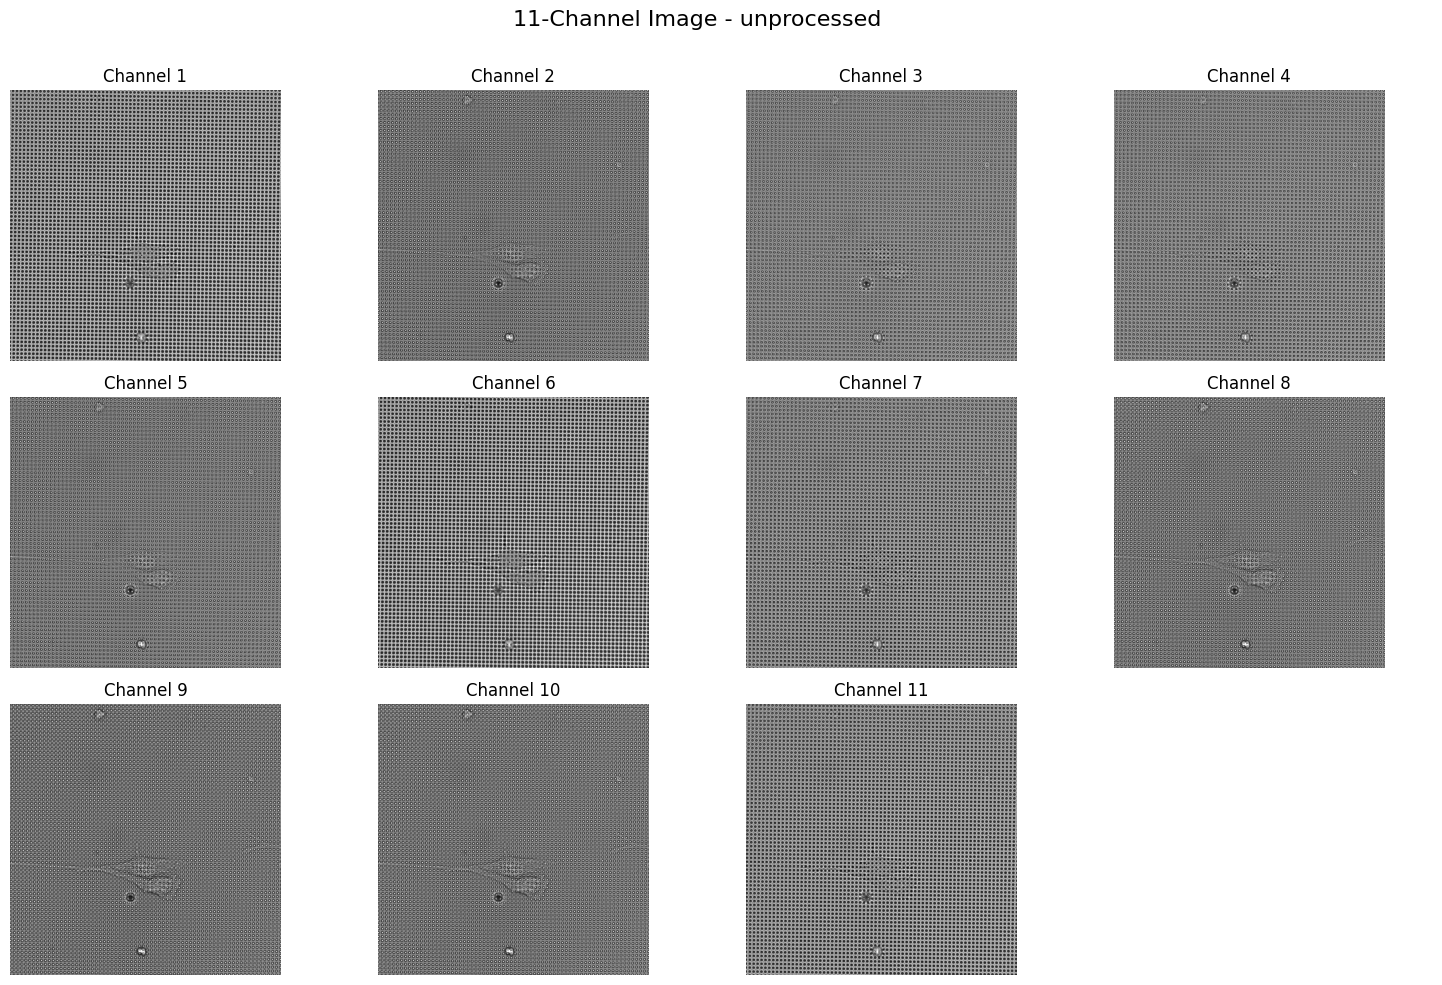

In [323]:
display_channels(image, subtitle='unprocessed')

In [ ]:
plt.figure(figsize=(15, 5))

# Subplot 1
plt.subplot(1, 4, 1)
plt.imshow(image[0], "gray")
plt.title("Original Image")

# Subplot 2
plt.subplot(1, 4, 2)
plt.imshow(preprocessed_channels[5, ...], 'gray')
plt.title("Preprocessed Channel 5")

# Subplot 3
plt.subplot(1, 4, 3)
plt.imshow(postprocessed_image, "gray")
plt.title("Result Mask")

# Subplot 4
plt.subplot(1, 4, 4)
plt.imshow(label, "gray")
plt.title("GT Mask")

plt.tight_layout()
plt.show()

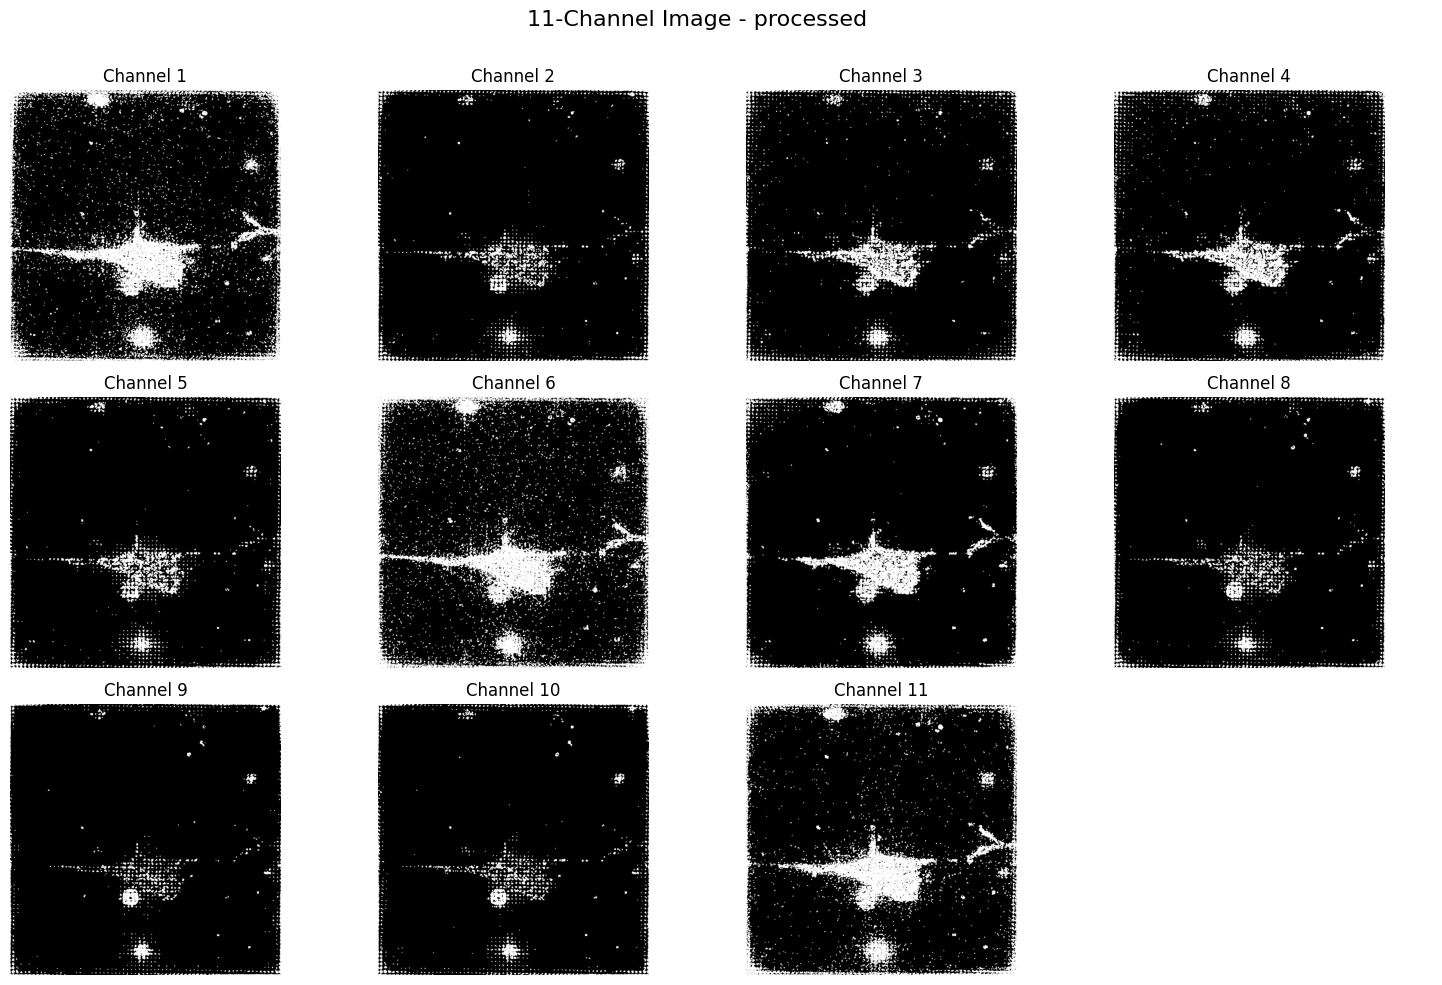

In [ ]:
display_channels(preprocessed_channels, subtitle='processed')